<a href="https://colab.research.google.com/github/Foulach/project_an/blob/main/regression2_ransac.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Essayons d'améliorer notre premier modèle de régression linéaire : https://colab.research.google.com/drive/1_nLU7TF3Ewx4vKUFTcwtBPWbTXgIxCa5#scrollTo=Oo_c--mlwQAr

Comme avec le premier, nous retirons l'année, la région et le pays du jeu de données.
Le score de bonheur est notre y (variable dépendante). Les variables x (indépendantes) sont :
*   PIB par habitant
*   Liberté de faire des choix de vie
*   Générosité
*   Espérance de vie en bonne santé
*   Perceptions de la corruption
*   Soutien social

Nous conservons les données pour toutes les années (2015 - 2023) sans procéder à aucune agrégation. Ainsi, nous avons une ligne pour chaque combinaison d'année, de pays et d'indicateur.

Les différences avec le premier modèle:

*   Nous avons complété davantage les données manquantes. Le ratio du PIB par habitant, tel qu'il était initialement présenté dans le World Happiness Report, a été remplacé par les valeurs réelles. Par conséquent, nous avons pu combler les données manquantes. Nos six variables ne contiennent désormais plus aucune donnée manquante.
*   Nous avons identifié les données aberrantes à l'aide de boxplots et d'histogrammes.
*   Une première analyse du facteur d'inflation de la variance (VIF) a été réalisée.
*   Une première analyse des coefficients a été effectuée.
*   Nous avons exécuté un modèle RANSAC.






## Data import and cleaning

In [ ]:
# import the dataset from google drive

import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/My Drive/happiness_project/regressions/whr_gdp.csv')
df.head()

Mounted at /content/drive


,year,country,region,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
0,2015,switzerland,western europe,7.587,84231.63,1.34951,0.94143,0.66557,0.29678,0.41978
1,2015,iceland,western europe,7.561,53227.63,1.40223,0.94784,0.62877,0.43630,0.14145
2,2015,denmark,western europe,7.527,53478.50,1.36058,0.87464,0.64938,0.34139,0.48357
3,2015,norway,western europe,7.522,74568.14,1.33095,0.88521,0.66973,0.34699,0.36503
4,2015,canada,north america and anz,7.427,43628.43,1.32261,0.90563,0.63297,0.45811,0.32957


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1152 entries, 0 to 1151
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          1152 non-null   int64  
 1   country                       1152 non-null   object 
 2   region                        1152 non-null   object 
 3   happiness_score               1152 non-null   float64
 4   gdp_per_capita                1152 non-null   float64
 5   social_support                1152 non-null   float64
 6   healthy_life_expectancy       1152 non-null   float64
 7   freedom_to_make_life_choices  1152 non-null   float64
 8   generosity                    1152 non-null   float64
 9   perceptions_of_corruption     1152 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 90.1+ KB


In [ ]:
df.isnull().sum()

,0
year,0
country,0
region,0
happiness_score,0
gdp_per_capita,0
social_support,0
healthy_life_expectancy,0
freedom_to_make_life_choices,0
generosity,0
perceptions_of_corruption,0


In [ ]:
# Let's continue our work on the values equal to 0 in our dataset.
# Is it because the real result of the study was 0, or did someone replace NaN by 0 when preparing the dataset?

# Find the location of all the values equal to 0
zero_locations = df[df == 0].stack().index.tolist()

# Extract relevant information for each zero value
zero_info = []
for index, column in zero_locations:
    country = df.loc[index, 'country']
    year = df.loc[index, 'year']
    zero_info.append({'country': country, 'year': year, 'column': column})

# Print the information for each zero value
for info in zero_info:
    print(f"Country: {info['country']}, Year: {info['year']}, Column: {info['column']}")

Country: indonesia, Year: 2015, Column: perceptions_of_corruption
Country: greece, Year: 2015, Column: generosity
Country: iraq, Year: 2015, Column: freedom_to_make_life_choices
Country: sierra leone, Year: 2015, Column: healthy_life_expectancy
Country: bosnia and herzegovina, Year: 2016, Column: perceptions_of_corruption
Country: greece, Year: 2016, Column: generosity
Country: sierra leone, Year: 2016, Column: healthy_life_expectancy
Country: togo, Year: 2016, Column: social_support
Country: greece, Year: 2017, Column: generosity
Country: bosnia and herzegovina, Year: 2017, Column: perceptions_of_corruption
Country: moldova, Year: 2018, Column: perceptions_of_corruption
Country: greece, Year: 2018, Column: generosity
Country: bosnia and herzegovina, Year: 2018, Column: perceptions_of_corruption
Country: sierra leone, Year: 2018, Column: healthy_life_expectancy
Country: moldova, Year: 2019, Column: perceptions_of_corruption
Country: greece, Year: 2019, Column: generosity
Country: afgha

In [ ]:
#inspect perceptions_of_corruption for Indonesia
print(df[(df['country'] == 'indonesia')]['perceptions_of_corruption'])
# Quelle est la moyenne pour tous les pays ?
print(df['perceptions_of_corruption'].mean())

63      0.000000
194     0.003220
327     0.015317
469     0.018000
594     0.028000
717     0.038279
844     0.046000
976     0.047000
1106    0.038000
Name: perceptions_of_corruption, dtype: float64
0.12968583790885418


**Conclusion** : il semble que la corruption augmente progressivement. Nous conserverons donc la valeur 0.

In [ ]:
#inspect freedom_to_make_life_choices for Iraq
print(df[(df['country'] == 'iraq')]['freedom_to_make_life_choices'])
# Quelle est la moyenne pour tous les pays ?
print(df['freedom_to_make_life_choices'].mean())

93      0.000000
222     0.248560
357     0.288556
485     0.304000
620     0.241000
738     0.283588
867     0.302000
991     0.328000
1117    0.351000
Name: freedom_to_make_life_choices, dtype: float64
0.4633378977821181


In [ ]:
# prompt: Calculate the mean for all the non-missing values from 'freedom_to_make_life_choices' column for country 'Iraq'. Then, replace the missing value with the mean

# Calculate the mean for all the non-missing values from 'freedom_to_make_life_choices' column for country 'Iraq'.
iraq_mean = df[(df['country'] == 'iraq') & (df['freedom_to_make_life_choices'] != 0)]['freedom_to_make_life_choices'].mean()

# Replace the missing value with the mean
df.loc[(df['country'] == 'iraq') & (df['freedom_to_make_life_choices'] == 0), 'freedom_to_make_life_choices'] = iraq_mean


In [ ]:
print(df[(df['country'] == 'iraq')]['freedom_to_make_life_choices'])

93      0.293338
222     0.248560
357     0.288556
485     0.304000
620     0.241000
738     0.283588
867     0.302000
991     0.328000
1117    0.351000
Name: freedom_to_make_life_choices, dtype: float64


In [ ]:
#inspect freedom_to_make_life_choices for afghanistan
print(df[(df['country'] == 'afghanistan')]['freedom_to_make_life_choices'])
# Quelle est la moyenne pour tous les pays ?
print(df['freedom_to_make_life_choices'].mean())

125     0.23414
254     0.16430
376     0.10618
507     0.08500
639     0.00000
767     0.00000
895     0.00000
1023    0.00000
1151    0.00000
Name: freedom_to_make_life_choices, dtype: float64
0.4635925314176432


**Conclusion** : il semble que la liberté s'est réduite dans le pays, probablement en raison de la radicalisation que nous observons dans plusieurs pays (Hongrie, Iran, France). Nous conserverons donc la valeur 0.

In [ ]:
#inspect perceptions_of_corruption for Bosnia and Herzegovina
print(df[(df['country'] == 'bosnia and herzegovina')]['perceptions_of_corruption'])
# Quelle est la moyenne pour tous les pays ?
print(df['perceptions_of_corruption'].mean())

81      0.002270
200     0.000000
335     0.000000
466     0.000000
583     0.006000
705     0.001172
829     0.005000
959     0.006000
1093    0.008000
Name: perceptions_of_corruption, dtype: float64
0.12968583790885418


**Conclusion**: le score est minime pendant toute la période. Nous conserverons donc la valeur 0.

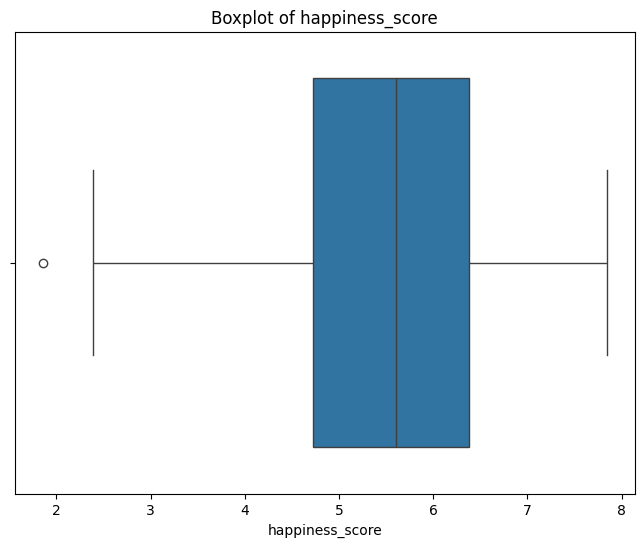

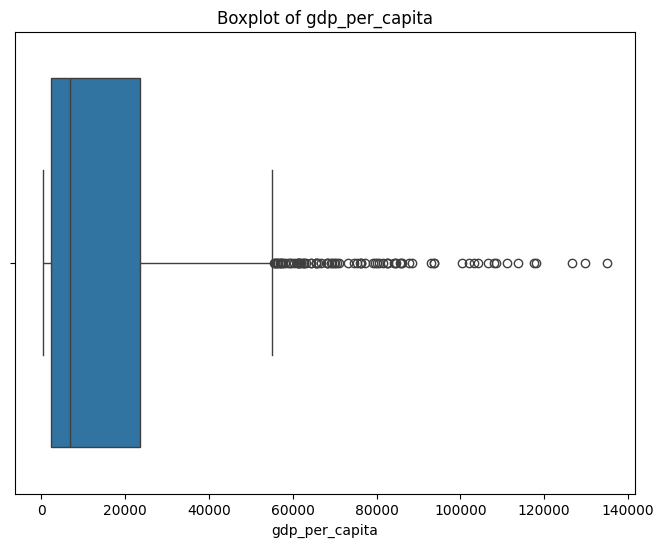

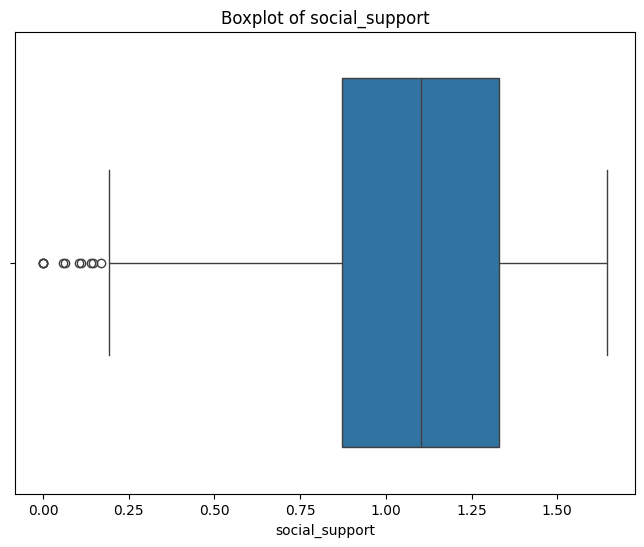

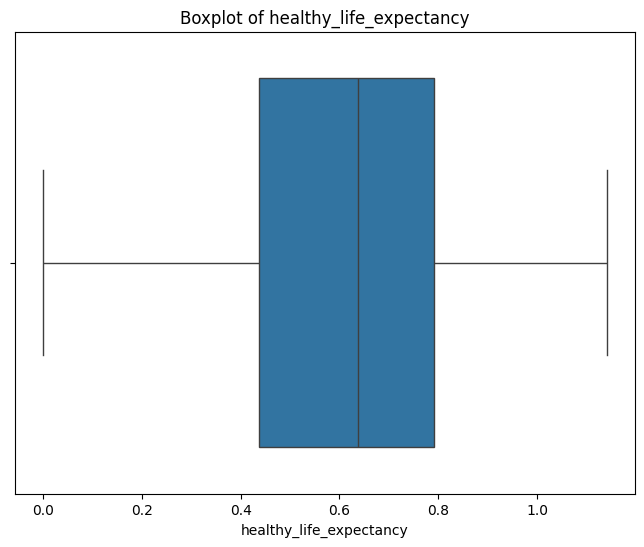

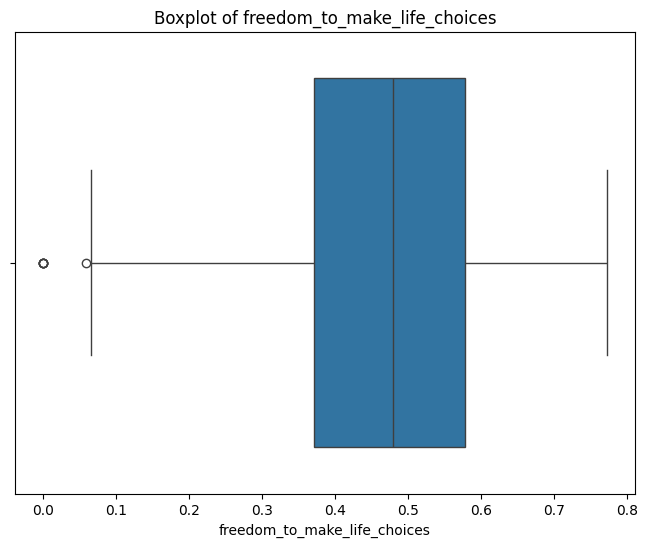

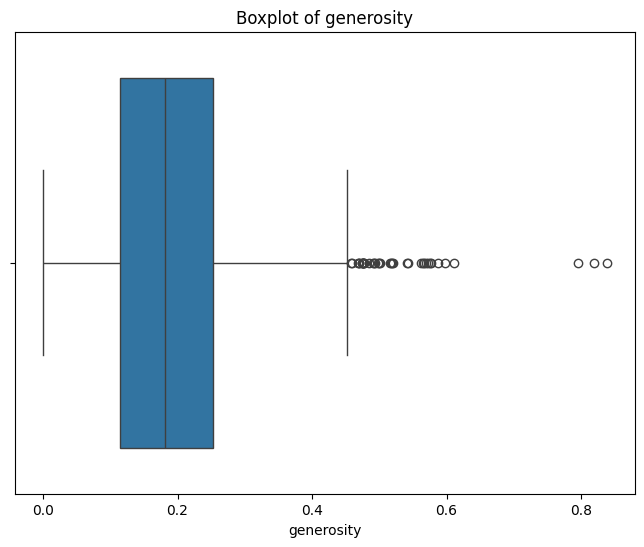

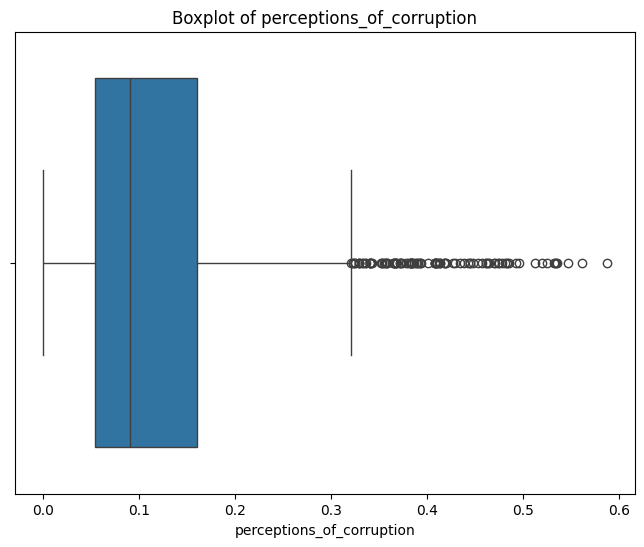

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sélectionner les colonnes numériques pour l'analyse
df_numeric = df[['happiness_score', 'gdp_per_capita', 'social_support',
                 'healthy_life_expectancy', 'freedom_to_make_life_choices',
                 'generosity', 'perceptions_of_corruption']]

# Créer des boxplots pour chaque colonne, un par un
for col in df_numeric.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x=df_numeric[col])
    plt.title(f"Boxplot of {col}")
    plt.show()

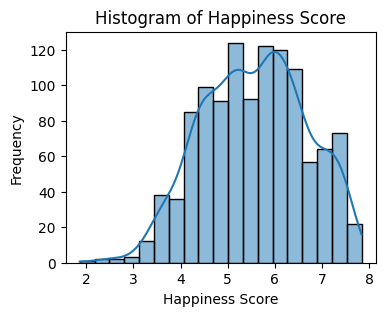

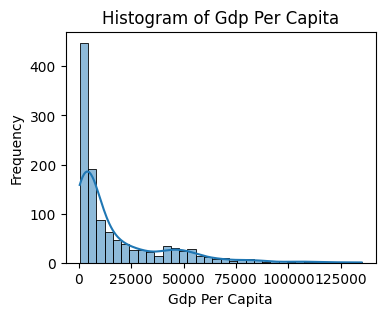

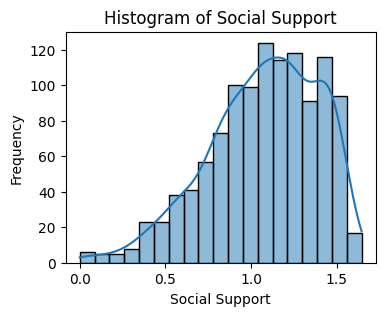

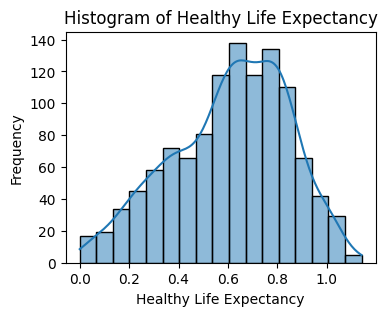

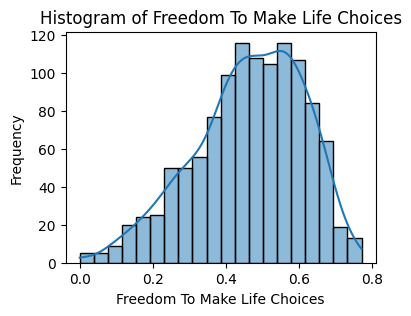

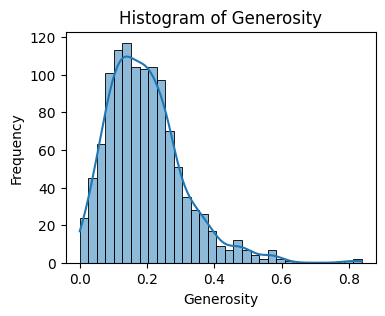

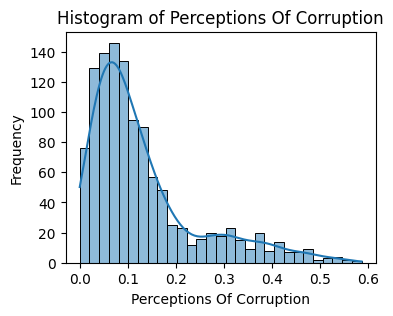

In [ ]:
# Sélectionner les colonnes numériques pour l'analyse
df_numeric = df[['happiness_score', 'gdp_per_capita', 'social_support',
                 'healthy_life_expectancy', 'freedom_to_make_life_choices',
                 'generosity', 'perceptions_of_corruption']]

# Créer des histogrammes pour chaque colonne
for col in df_numeric.columns:
    plt.figure(figsize=(4, 3))
    sns.histplot(df[col], kde=True)
    plt.title(f"Histogram of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Frequency")
    plt.show()

**Conclusions**:
*   GDP_per_capita comporte des outliers.
*   Les distributions ne représentent aucune multimodalité.



### Z Test

In [ ]:
# Étape 2 : Calculer les Z-scores pour détecter les valeurs aberrantes
import scipy.stats as stats # Import the stats module from scipy

# Calculer les Z-scores pour chaque colonne numérique
df_z_scores = pd.DataFrame(stats.zscore(df_numeric), columns=df_numeric.columns)

# Filtrer les valeurs aberrantes (Z-score > 3 ou < -3)
outliers_detected = df_z_scores[(df_z_scores > 3) | (df_z_scores < -3)].dropna(how='all')

# Afficher les valeurs aberrantes détectées
outliers_detected

,happiness_score,gdp_per_capita,social_support,healthy_life_expectancy,freedom_to_make_life_choices,generosity,perceptions_of_corruption
2,NaN,NaN,NaN,NaN,NaN,NaN,3.119374
16,NaN,3.978382,NaN,NaN,NaN,NaN,NaN
22,NaN,NaN,NaN,NaN,NaN,NaN,3.194563
31,NaN,NaN,NaN,NaN,NaN,3.367724,NaN
106,NaN,NaN,NaN,NaN,NaN,5.306535,NaN
...,...,...,...,...,...,...,...
1032,NaN,5.005140,NaN,NaN,NaN,NaN,NaN
1033,NaN,NaN,NaN,NaN,NaN,NaN,3.008573
1037,NaN,3.870008,NaN,NaN,NaN,NaN,NaN
1048,NaN,3.001586,NaN,NaN,NaN,NaN,3.801894


## Modeling

### Preprocessing

In [ ]:
# Select relevant columns for X and y
X = df[['gdp_per_capita', 'social_support', 'healthy_life_expectancy',
         'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption']]
y = df['happiness_score']

In [ ]:
# Split into train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [ ]:
# Scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Train a Linear Regression model that predicts happiness_score (our y) based on our X variables.

from sklearn.linear_model import LinearRegression
model_1 = LinearRegression().fit(X_train_scaled, y_train)

### Evaluation

In [ ]:
# Score the model

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Make predictions on the test set
y_pred = model_1.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print("R-squared:", r2)
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

R-squared: 0.7219890738216884
Mean Squared Error: 0.30103473461760055
Mean Absolute Error: 0.4305769739727798


## Coefficients et leur interprétation

In [ ]:
# Obtenir les coefficients du modèle
coefficients = model_1.coef_
intercept = model_1.intercept_

# Afficher les coefficients
print("Intercept:", intercept)
print("Coefficients:", coefficients)

# Associer les coefficients aux noms des colonnes pour une interprétation plus facile
for name, coef in zip(X.columns, coefficients):
    print(f"{name}: {coef}")

Intercept: 5.553365037648209
Coefficients: [ 0.38317388  0.25825138  0.32050485  0.26802217 -0.03343436  0.02372325]
gdp_per_capita: 0.3831738820798822
social_support: 0.25825137725843034
healthy_life_expectancy: 0.32050485020890773
freedom_to_make_life_choices: 0.26802217314736054
generosity: -0.03343436239458049
perceptions_of_corruption: 0.02372325111933693


## Variance Inflation Factor (VIF)

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Utiliser les mêmes données que pour la régression linéaire
X = df[['gdp_per_capita', 'social_support', 'healthy_life_expectancy',
        'freedom_to_make_life_choices', 'generosity', 'perceptions_of_corruption']]

# Ajouter une constante pour l'intercept
X = sm.add_constant(X)

# Calcul du VIF pour chaque variable
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Afficher les résultats
print(vif_data)



                        feature        VIF
0                         const  24.003975
1                gdp_per_capita   2.833133
2                social_support   1.680543
3       healthy_life_expectancy   1.725121
4  freedom_to_make_life_choices   1.443915
5                    generosity   1.073136
6     perceptions_of_corruption   2.335694



# RANSAC MODEL

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression, RANSACRegressor
from sklearn.datasets import make_regression

In [ ]:
# Initialisation du modèle de régression linéaire
linear_model = LinearRegression()

# Initialisation du modèle RANSAC
ransac = RANSACRegressor(linear_model,
                         min_samples=50,  # Nombre minimum d'échantillons pour ajuster le modèle
                         residual_threshold=10.0,  # Seuil pour identifier les inliers
                         max_trials=100)  # Nombre maximum d'itérations pour essayer de trouver un modèle valide

# Entraînement du modèle RANSAC
ransac.fit(X, y)

RANSACRegressor(estimator=LinearRegression(), min_samples=50,
                residual_threshold=10.0)

In [ ]:
# Prédictions sur les données d'entraînement
y_pred = ransac.predict(X)

# Coefficients du modèle final
inlier_mask = ransac.inlier_mask_  # Masque des inliers
outlier_mask = np.logical_not(inlier_mask)  # Masque des outliers

print(f'Coefficient: {ransac.estimator_.coef_}')
print(f'Intercept: {ransac.estimator_.intercept_}')

# Associer les coefficients aux noms des colonnes pour une interprétation plus facile
for name, coef in zip(X.columns, coefficients):
    print(f"{name}: {coef}")

Coefficient: [ 0.00000000e+00  1.63994775e-05  7.88809062e-01  1.36894116e+00
  1.86306750e+00 -1.51418763e-01  1.39675221e-01]
Intercept: 2.7530250230984783
const: 0.3831738820798822
gdp_per_capita: 0.25825137725843034
social_support: 0.32050485020890773
healthy_life_expectancy: 0.26802217314736054
freedom_to_make_life_choices: -0.03343436239458049
generosity: 0.02372325111933693


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = ransac.predict(X)
print(f'R2 Score: {r2_score(y, y_pred)}')
print(f'Mean Squared Error: {mean_squared_error(y, y_pred)}')

R2 Score: 0.7314741099681983
Mean Squared Error: 0.3222863428888756



Un R-squared de 0 n'indique aucune corrélations entres variables. Un R-squared de 1 indique une corrélation parfaite. Notre R-squared de 0,73 indique bien une corrélation entre le bonheur et les autres variables prises en compte.

Mean squared error indique l'éloignement des points par rapport à la ligne de regression. Le but est d'avoir un score le plus proche de 0 possible. A 0,3, les valeurs du dataset sont proches de la régression.